In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal, ndimage
from scipy.optimize import curve_fit

## Importing data

In [ ]:
pert_strength = 0.3
dir_name_HA = 'T:/Team/Szewczyk/Data/2024-07-17/'
dir_name_LA = 'T:/Team/Szewczyk/Data/2024-02-22/'

In [ ]:
current_HA = pd.read_csv(dir_name_HA+'example_period.csv')
current_LA = pd.read_csv(dir_name_LA+'example_period.csv')
prc = pd.read_csv(dir_name_LA+'prc.csv')
prc['norm_response'] = prc.response/pert_strength

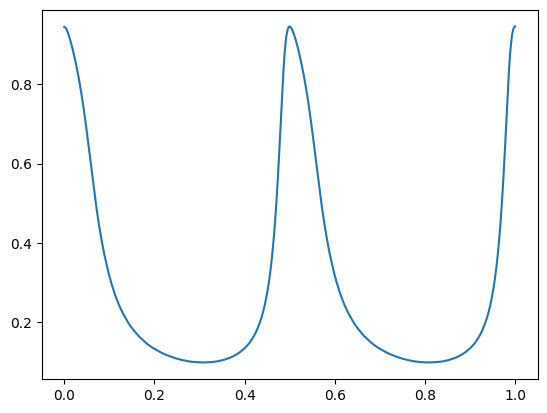

In [ ]:
current_HA.phase = current_HA.phase/2
current_copy = current_HA.copy()
current_copy.phase = current_copy.phase+0.5
current_copy.t = current_copy.t+current_copy.t.iloc[-1]
current_HA = pd.concat([current_HA, current_copy])
plt.plot(current_HA.phase, current_HA.I)

## PRC fitting

In [ ]:
def gaussian(x, h, m, s):
    d = np.minimum(np.abs(x-m), 1-np.abs(x-m))
    return h*np.exp(-d**2/(2*s))

def curve(x, h1, m1, s1, h2, m2, s2):
    return gaussian(x, h1, m1, s1) + gaussian(x, h2, m2, s2)

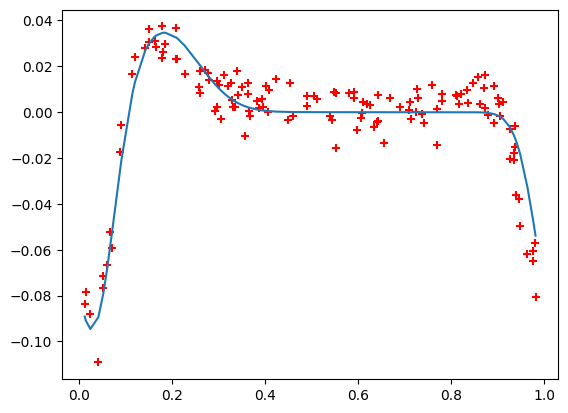

In [ ]:
initial_guess = (0.035, 0.18, 0.006, -0.1, 0.03, 0.002)
plt.figure()
plt.plot(prc.phase, curve(prc.phase, *initial_guess))
plt.scatter(prc.phase, prc.norm_response, marker='+', c='r')

In [ ]:
popt, popc = curve_fit(curve, prc.phase, prc.norm_response, initial_guess)

In [ ]:
def fitted_prc(x):
    return curve(x%1, *popt)

## LA and HA current comparison

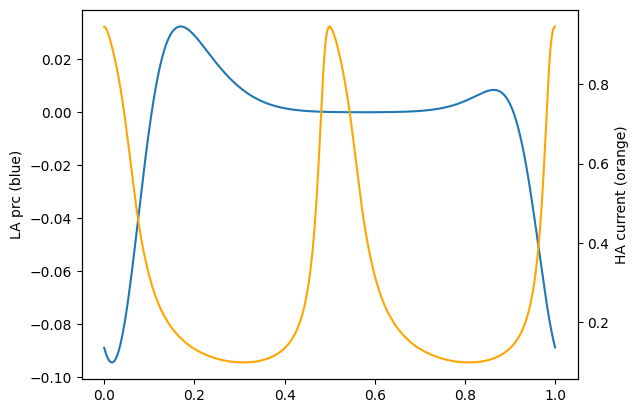

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(current_HA.phase, fitted_prc(current_HA.phase))
ax1.set_ylabel('LA prc (blue)')
ax2.plot(current_HA.phase, current_HA.I, c='orange')
ax2.set_ylabel('HA current (orange)')
plt.show()

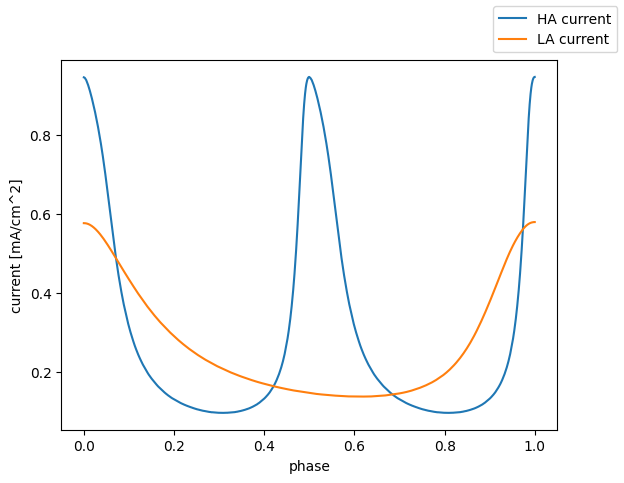

In [ ]:
fig, ax = plt.subplots()
ax.plot(current_HA.phase, current_HA.I, label='HA current')
ax.plot(current_LA.phase, current_LA.I, label='LA current')
ax.set_xlabel('phase')
ax.set_ylabel('current [mA/cm^2]')
fig.legend()

In [ ]:
print(np.mean(current_LA.I), np.mean(current_HA.I))

0.26964086409940957 0.29411296374083185


Average HA current density is slightly larger than that of LA

In [ ]:
def HA_current_fit(d=0):
    return np.interp((current_LA.phase+d)%1, current_HA.phase, current_HA.I)

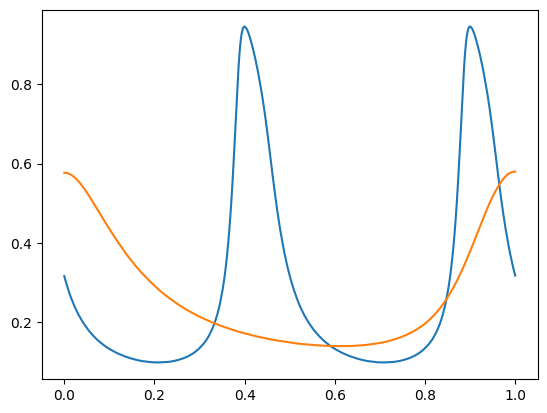

In [ ]:
plt.plot(current_LA.phase, HA_current_fit(0.1))
plt.plot(current_LA.phase, current_LA.I)

`HA_current_fit` translates HA current to LA phase. When `d` is small and positive, it means that the LA oscillation is slightly ahead $\iff$ HA is slightly lagging. For synchronisation, we expect the LA to slow down for small positive `d` and speed for small negative `d`.

`d` can be thought of as the $x$ coordinate of the LA peak when working in HA phase.

## EMSI comparison

0.1408533337454048


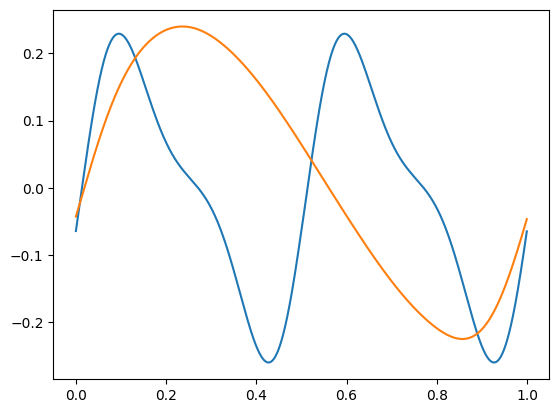

In [ ]:
plt.plot(current_HA.phase, current_HA.emsi_corrected)
plt.plot(current_LA.phase, current_LA.emsi_corrected)
print(current_LA.phase.iloc[np.argmax(current_LA.emsi_corrected)]-current_HA.phase.iloc[np.argmax(current_HA.emsi_corrected)])

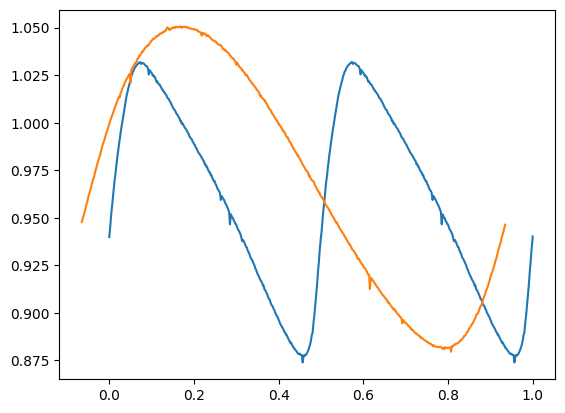

In [ ]:
plt.plot(current_HA.phase, current_HA.emsi/25-0.55)#_corrected)
plt.plot(current_LA.phase-0.065, current_LA.emsi/20)#_corrected)

## Calculating the interaction function

F is the integral:

$$\int_0^1 \mathrm{PRC}_\mathrm{LA}(\phi)[j_\mathrm{HA}(\phi+\Delta \phi) - j_\mathrm{LA} (\phi)] d\phi$$

In [ ]:
def F(delta_phi):
    return np.sum(fitted_prc(current_LA.phase)*(HA_current_fit(delta_phi)-current_LA.I))/current_LA.phase.size

In [ ]:
effect = np.zeros_like(current_LA.phase)
for i, d in enumerate(current_LA.phase):
    effect[i] = F(d)*current_LA.t.iloc[-1]

In [ ]:
effect_pd = pd.DataFrame({
    'delta_phi'     : current_LA.phase,
    'effect'        : effect
})
effect_pd.to_csv('effect_LAHA.csv')

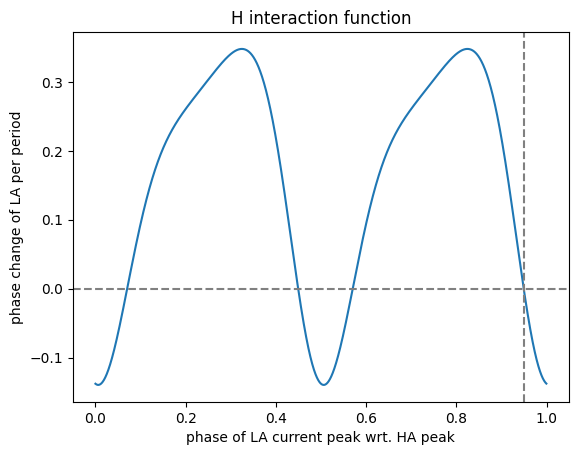

In [ ]:
plt.plot(current_LA.phase, effect)
plt.title("H interaction function")
plt.xlabel("phase of LA current peak wrt. HA peak")
plt.ylabel("phase change of LA per period")
plt.axhline(0, ls='--', c='gray')
plt.axvline(0.95, ls='--', c='gray')

We expect the LA current peak to be lagging slightly, by about 0.05 of the LA period.